In [1]:
%matplotlib widget

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime
import os
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.time import Time
import healpy as hpy

from vasca.resource_manager import ResourceManager
from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
import vasca.utils as vutils

In [4]:
out_dir = "/Users/julianschliwinski/Library/Mobile Documents/com~apple~CloudDocs/PhD/MM School/prersentations/Annual Meeting 2023-06-05/input"

# Compare Time Domain Survey and VASCA catalogs

## Load data

### Load VASCA region

In [5]:
#region_name = "TDS_ELAISN1"
region_name = "TDS_ALL"
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
display(rg.tt_fields)

field_id,field_name,ra,dec,observatory,obs_filter,fov_diam,sel,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id
,,deg,deg,,,deg,,,s,d,d,
bytes22,bytes22,float64,float64,bytes22,bytes8,float32,bool,int32,float32,float64,float64,int32
GNU2592597978464124928,PS_XMMLSS_MOS00,35.578863351058885,-3.14176421214975,GALEX,NUV,1.2,True,27,40457.25,54791.262777777774,57213.3405928096,0
GNU2592668347208302592,PS_XMMLSS_MOS01,36.49984981667359,-3.4923125504146,GALEX,NUV,1.2,True,26,38608.996,54791.33122685185,57205.55893265336,1
GNU2592738715952480256,PS_XMMLSS_MOS02,34.995648096666685,-3.95320684099725,GALEX,NUV,1.2,True,24,23118.55,54791.399976851855,56670.07746654369,2
GNU2592809084696657920,PS_XMMLSS_MOS03,35.87152971805409,-4.25258328683038,GALEX,NUV,1.2,True,21,31699.102,54791.468136574076,57205.5459979022,3
GNU2592879453440835584,PS_XMMLSS_MOS04,36.890941423843685,-4.42319486511272,GALEX,NUV,1.2,True,23,34784.05,54791.53658564815,57214.614389105904,4
GNU2592949822185013248,PS_XMMLSS_MOS05,35.19163328261652,-5.0517494636978,GALEX,NUV,1.2,True,22,32845.8,54791.60503472222,57205.68289605035,5
GNU2593020190929190912,PS_XMMLSS_MOS06,36.220702772470815,-5.20539528501055,GALEX,NUV,1.2,True,23,33876.6,54791.673472222225,57206.85126283999,6
GNU2593653509626789888,PS_CDFS_MOS00,53.10325584718021,-27.796382607231,GALEX,NUV,1.2,True,117,185705.4,54812.34815972222,56994.373020833336,7


In [6]:
# Number of visits
n_visits = rg.tt_fields["nr_vis"].sum()
# GALEX field ids, stripy VASCA ID prefix
galex_field_ids = np.unique([vid[3:]for vid in rg.tt_fields["field_id"]]).tolist()
# Number of GALEX fields
n_fields = len(galex_field_ids)
# Sky area
a_sky = n_fields * 1.2 * u.deg
print(f"n_visits: {n_visits}")
print(f"n_fields: {n_fields}")
print(f"a_sky: {a_sky}")

n_visits: 2402
n_fields: 42
a_sky: 50.4 deg


### Load global GALEX visits table

In [7]:
with ResourceManager() as rm:
    path = rm.get_path("gal_visits_list", "sas_cloud")
    tt_gal_vis = Table.read(path)

In [8]:
# Selects only visits that are in given region
sel_rg = np.isin(tt_gal_vis["imgRunID"],rg.tt_visits["vis_id"])

In [9]:
tt_rg_vis = tt_gal_vis[sel_rg]
tt_rg_vis.info

<Table length=1201>
      name        dtype 
---------------- -------
    RATileCenter float64
   DECTileCenter float64
          survey  bytes3
        nexptime float64
        fexptime float64
        imgRunID   int64
  ParentImgRunID   int64
          joinID   int64
         tileNum   int64
     specTileNum   int64
          source  bytes6
   nPhotoObjects   int64
    nPhotoVisits   int64
    PhotoObsDate bytes22
         spectra  bytes5
        nSpectra  bytes4
  nSpectraVisits  bytes4
     SpecObsDate  bytes4
        visitNum   int64
          subvis   int64
 minPhotoObsDate bytes22
 maxPhotoObsDate bytes22
  minSpecObsDate  bytes4
  maxSpecObsDate  bytes4
PhotoObsDate_MJD float64
            gall float64
            galb float64

### Load TDS catalog

In [10]:
# Read TDS fits file
tt_tds_all = Table.read("./TDS-ApJ_766_60/table4.fit", hdu="J_ApJ_766_60_table4")
ids = tt_tds_all["ID"].data.astype(dtype=str)
sel_elai = (np.char.find(ids, 'ELAI') > -1)
tt_tds = tt_tds_all
if "ELAISN1" in region_fname:    # restrict ELAISN1 fields
    tt_tds = tt_tds_all[sel_elai]
tt_tds['RAJ2000'].name = 'ra'
tt_tds['DEJ2000'].name = 'dec'

## Observations timeline

In [11]:
vutils.extr_value(tt_rg_vis["nexptime","fexptime"], upper=True)

1706.0

In [12]:
# Bounds and normalization for colors
expt_min = vutils.extr_value(tt_rg_vis["nexptime","fexptime"], upper=False)
expt_max = vutils.extr_value(tt_rg_vis["nexptime","fexptime"], upper=True)
c_norm = Normalize(vmin=expt_min, vmax=expt_max)
c_lognorm = LogNorm(vmin=expt_min, vmax=expt_max)

print(f"Exposure times (NUV & FUV): min = {expt_min * u.s}, max = {expt_max * u.s}")

Exposure times (NUV & FUV): min = 0.0 s, max = 1706.0 s


In [13]:
print("Average exporsure time")
print(f"NUV {tt_rg_vis['nexptime'].mean() / 60:2.2f} min")
print(f"FUV {tt_rg_vis['fexptime'].mean() / 60:2.2f} min")

Average exporsure time
NUV 22.44 min
FUV 3.17 min


In [14]:
print("Average number of visits")
print(f"NUV {rg.tt_fields['nr_vis'][rg.tt_fields['obs_filter'] == 'NUV'].mean()}")
print(f"FUV {rg.tt_fields['nr_vis'][rg.tt_fields['obs_filter'] == 'FUV'].mean()}")

Average number of visits
NUV 28.595238095238095
FUV 28.595238095238095


In [15]:
np.unique(rg.tt_fields["obs_filter"]).tolist()

['FUV', 'NUV']

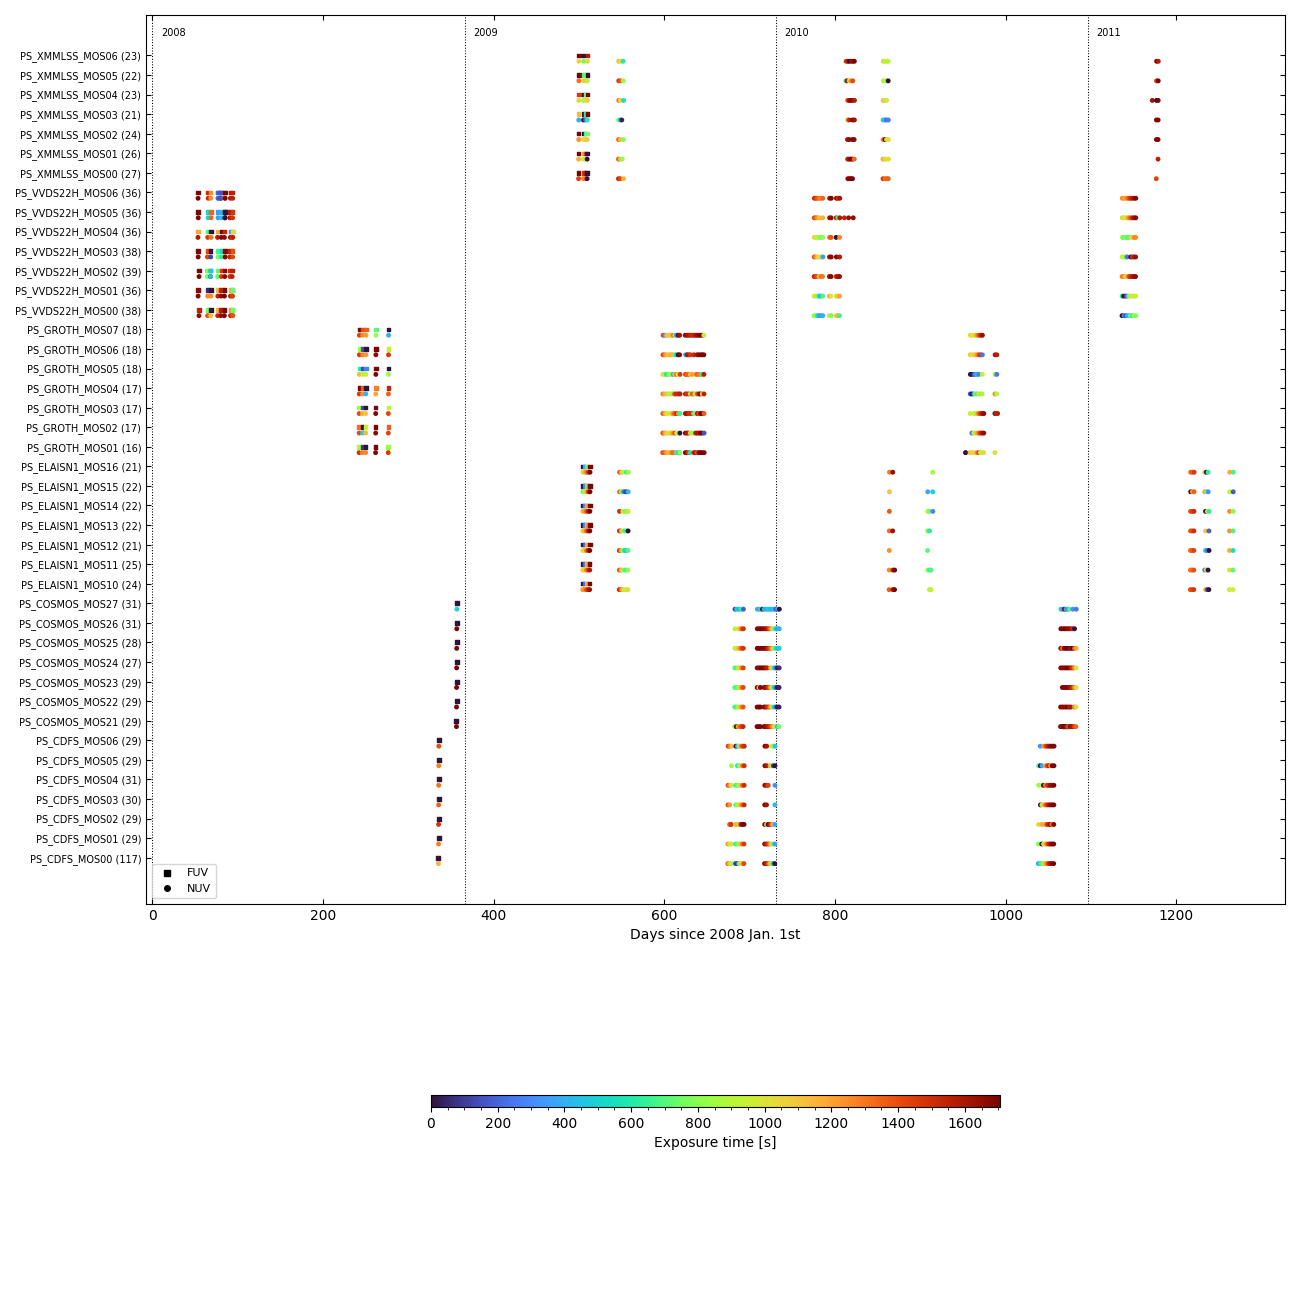

In [16]:
field_ids = np.unique(tt_rg_vis["ParentImgRunID"].data)

# Find year marks
dates = Time(tt_rg_vis["PhotoObsDate_MJD"], format="mjd").to_value(
        "datetime"
    )
years = np.unique([d.year for d in dates])

# Setup figure
fig, ax = vutils.nb_fig(num="GALEX TDS (NUV)", figsize=(13,13), layout="tight")

cmap_name = "turbo"
cmap_norm = c_norm

# Loops over fields
for i, fd_id in enumerate(field_ids):
    
    # Loops over filters
    obs_filters = np.unique(rg.tt_fields["obs_filter"]).tolist()
    fd_id_prefix = {
        "FUV": "GFU",
        "NUV": "GNU"
    }
    exptime_key = {
        "FUV": "fexptime",
        "NUV": "nexptime"
    }
    y_offset = {
        "FUV": 0,
        "NUV": 0.3
    }
    markers = {
        "FUV": "s",
        "NUV": "o"
    }
    for obs_filter in obs_filters:
    
        # Selects only visits of given field
        sel_fd = tt_rg_vis["ParentImgRunID"] == fd_id
        
        # Selects only visits with exposure time above 0.0
        sel_expt = tt_rg_vis[exptime_key[obs_filter]] > 0.0
        
        tt_fd_vis = tt_rg_vis[np.logical_and(sel_fd, sel_expt)]

        # Single-row table with field info
        tt_fd_info = rg.tt_fields[rg.tt_fields["field_id"] == f"{fd_id_prefix[obs_filter]}{fd_id}"]
        
        fd_name = tt_fd_info['field_name'].data[0].decode("UTF-8")
        fd_n_vis = len(tt_fd_vis)#tt_fd_info['nr_vis'].data[0]

        # Reference date, Jan. 1st in year of first oservation
        mjd_ref = Time(f"{years[0]}-01-01T00:00:00.000", format="isot", scale="utc").mjd - 10

        # Draw visits
        y_vals = np.zeros(fd_n_vis) + i - y_offset[obs_filter]
        data_plot = ax.scatter(
            tt_fd_vis["PhotoObsDate_MJD"] - mjd_ref, y_vals,
            marker=markers[obs_filter],
            s=2.5**2,
            c=cmap_norm(tt_fd_vis[exptime_key[obs_filter]]),
            cmap=cmap_name
        )

# x-axis label
ax.set_xlabel(f"Days since {years[0]} Jan. 1st")
    
# Sets field names as y-ticks labels
field_names = np.unique([f"{str(row['field_name'])} ({row['nr_vis']})" for row in rg.tt_fields])
ax.set_yticks(np.arange(len(field_names)))
#ax.set_yticklabels([f"{str(row['field_name'])} ({row['nr_vis']})" for row in rg.tt_fields], fontsize=7)
ax.set_yticklabels(field_names, fontsize=7)

# Draw year marks
for year in years:
    year_mark = Time(f"{str(year)}-01-01T00:00:00.000", format="isot", scale="utc").mjd - (mjd_ref + 10)
    ax.text(year_mark + 10, n_fields, f"{year}", fontsize=7)
    ax.axvline(year_mark, ls=":", lw=0.75, color="k", zorder=0)

# Color bar
cbar = fig.colorbar(
    cm.ScalarMappable(norm=cmap_norm, cmap=cmap_name),
    ax=ax,
    orientation="horizontal",
    shrink=0.5,
    aspect=45,
    label="Exposure time [s]"
)
cbar.minorticks_on()

# Legend
legend_elements = [Line2D([0], [0], marker=markers[obs_filter], color="k", ls="", ms=4, label=obs_filter) for obs_filter in obs_filters]
ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0.00, 0.0), fontsize=8)

# Axis style
ax.tick_params(axis="y", direction="in", left=True, right=True, which="both")
ax.tick_params(axis="x", direction="in", top=True, bottom=True, which="both")

#ax.set_xscale("log")

## Sky maps

In [17]:
#Creat field table
tt_gal_vis_grp = tt_gal_vis.group_by('ParentImgRunID')
tt_gal_vis_grp_mean = tt_gal_vis_grp["gall","galb","nexptime"].groups.aggregate(np.mean)
tt_fd = Table()
tt_fd["field_id"] = np.array(list(tt_gal_vis_grp.groups.keys["ParentImgRunID"]))
grp_idx = tt_gal_vis_grp.groups.indices
tt_fd["nr_vis"] = grp_idx[1:]-grp_idx[0:-1]
tt_fd["nexptime_mean"]= tt_gal_vis_grp_mean["nexptime"]
tt_fd["gall"]= tt_gal_vis_grp_mean["gall"]
tt_fd["galb"]= tt_gal_vis_grp_mean["galb"]

In [18]:
#Select fields
sel_fd_nexptime = tt_fd["nexptime_mean"]>700
sel_fd_nr_vis = tt_fd["nr_vis"]>2
sel_fd_nr_vis_tds_9 = tt_fd["nr_vis"] >= 9
sel_fd_nr_vis_tds_16 = tt_fd["nr_vis"] >= 16
sel_fds_tds = np.isin(tt_fd["field_id"], field_ids)
#sel_fd = sel_fd_nexptime*sel_fd_nr_vis
sel_fd = sel_fds_tds
print("Selected fields have a total number of visits of:",tt_fd[sel_fd]["nr_vis"].sum())

Selected fields have a total number of visits of: 1201


In [19]:
#Setup high res plotting data
nside_hres     = 2**12
print(nside_hres)
npix_hres = hpy.nside2npix(nside_hres)
pix_diam_hres = hpy.nside2resol(nside_hres, arcmin=True) / 60 * u.deg
print("High resolution pixel diameter:",np.round(pix_diam_hres,4),"Npix:",npix_hres,"Nside:",nside_hres)
tt_fd["hvec"] = hpy.ang2vec(tt_fd["gall"],tt_fd["galb"],lonlat=True)

nr_vis_hres = np.zeros(npix_hres)  # empty map
nr_fd_hres = np.zeros(npix_hres)  # empty map
a_tds_v_vasca_hres = np.zeros(npix_hres)  # empty map
GALEX_FOV = 0.5  # disc radius in deg

# fill map with coverage data
for fd in tt_fd[sel_fds_tds]:
    ipix_disc = hpy.query_disc(nside=nside_hres, vec=fd["hvec"], radius=np.radians(GALEX_FOV))
    nr_fd_hres[ipix_disc] += 1  # number of fields
    nr_vis_hres[ipix_disc] += fd["nr_vis"]

# VASCA potential coverage
cvals = [2.0 , 5.0, 7.0, 9.5, 14.5]
cvals = np.linspace(2,15,4)
for fd in tt_fd[sel_fd_nr_vis]:
    ipix_disc = hpy.query_disc(nside=nside_hres, vec=fd["hvec"], radius=np.radians(GALEX_FOV))
    a_tds_v_vasca_hres[ipix_disc] = cvals[0]
for fd in tt_fd[sel_fd_nr_vis_tds_9]:
    ipix_disc = hpy.query_disc(nside=nside_hres, vec=fd["hvec"], radius=np.radians(GALEX_FOV))
    a_tds_v_vasca_hres[ipix_disc] = cvals[1]
for fd in tt_fd[sel_fd_nr_vis_tds_16]:
    ipix_disc = hpy.query_disc(nside=nside_hres, vec=fd["hvec"], radius=np.radians(GALEX_FOV))
    a_tds_v_vasca_hres[ipix_disc] = cvals[2]
for fd in tt_fd[sel_fds_tds]:
    ipix_disc = hpy.query_disc(nside=nside_hres, vec=fd["hvec"], radius=np.radians(GALEX_FOV))
    a_tds_v_vasca_hres[ipix_disc] = cvals[3]

4096
High resolution pixel diameter: 0.0143 deg Npix: 201326592 Nside: 4096


In [20]:
np.linspace(2,15,4)

array([ 2.        ,  6.33333333, 10.66666667, 15.        ])

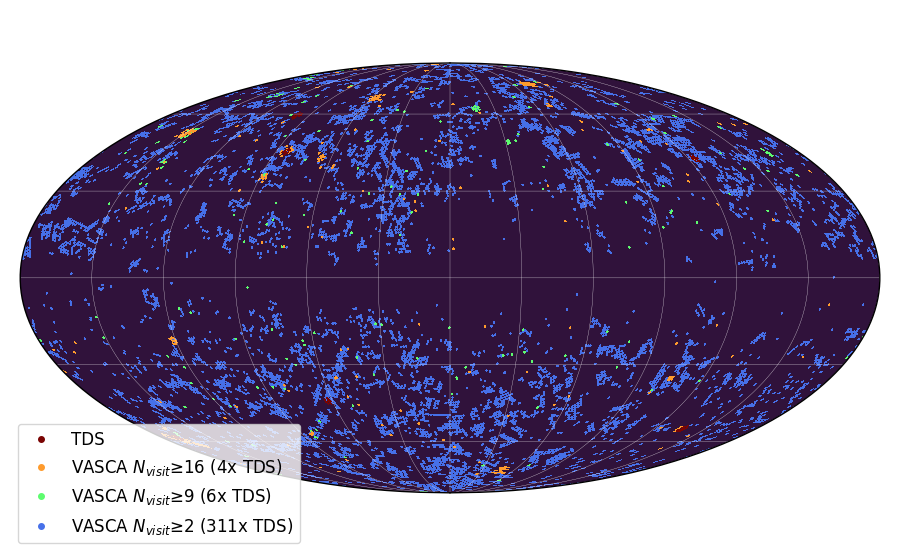

In [21]:
# setup figure
gr_size = 9
gr = (1 + 5**0.5) / 2
fig_size = (gr_size, gr_size / gr)
num = "sky cov"
plt.close(num)
fig = plt.figure(num=num, figsize=fig_size)

# colorbar
vmin = 0
vmax = 15
c_norm = Normalize(vmin=vmin, vmax=vmax)

# custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color=cm.turbo(c_norm(cvals[3])), ls="", label='TDS', markersize=4),
    Line2D([0], [0], marker='o', color=cm.turbo(c_norm(cvals[2])), ls="", label='VASCA $N_{{visit}} ≥ 16$ (4x TDS)', markersize=4),
    Line2D([0], [0], marker='o', color=cm.turbo(c_norm(cvals[1])), ls="", label='VASCA $N_{{visit}} ≥ 9$ (6x TDS)', markersize=4),
    Line2D([0], [0], marker='o', color=cm.turbo(c_norm(cvals[0])), ls="", label='VASCA $N_{{visit}} ≥ 2$ (311x TDS)', markersize=4),
]



hpy.mollview(
    a_tds_v_vasca_hres,
    fig=fig,
    title=None,#"GALEX multi-visit sky coverage",
    nest=False,
    cmap="turbo",
    cbar=None,
    min=vmin,
    max=vmax,
    xsize=5000
)
hpy.graticule(color="w", lw=0.2, ls="-")
ax = plt.gca()
ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=[-0.01, -0.13], fontsize=12)

plt.savefig(f"{out_dir}/sky_cov.pdf", dpi=600)
plt.savefig(f"{out_dir}/sky_cov.svg", dpi=600)
plt.savefig(f"{out_dir}/sky_cov.png", dpi=600)

## Visit statistics

### Aggregate statistics using pandas

In [22]:
# GALEX visits info as DataFrame
df_gal_vis = tt_gal_vis.to_pandas()

# Convert survey column to proper stings
df_gal_vis["survey"] = df_gal_vis["survey"].values.astype(str)

# Sorted by survey and visit ID
df_gal_vis_grpd = df_gal_vis.groupby(["survey","ParentImgRunID"],as_index=True)

In [23]:
# Access single group
df_gal_vis_grpd.get_group(("DIS", 2592597978464124928))

,RATileCenter,DECTileCenter,survey,nexptime,fexptime,imgRunID,ParentImgRunID,joinID,tileNum,specTileNum,...,SpecObsDate,visitNum,subvis,minPhotoObsDate,maxPhotoObsDate,minSpecObsDate,maxSpecObsDate,PhotoObsDate_MJD,gall,galb
9904,35.605017,-3.148295,DIS,1540.20,1540.2,2592597840823844864,2592597978464124928,30700,8150,-999,...,b'null',1,-999,b'11/21/2008 6:18:24 AM',b'11/21/2008 6:44:04 AM',b'null',b'null',54791.262778,169.070510,-57.626828
9905,35.586541,-3.154902,DIS,1589.15,0.0,2592597840857399296,2592597978464124928,54470,8150,-999,...,b'null',2,-999,b'10/26/2009 9:16:59 AM',b'10/26/2009 9:43:28 AM',b'null',b'null',55130.386794,169.052035,-57.643744
9906,35.582341,-3.134771,DIS,1524.20,0.0,2592597840890953728,2592597978464124928,35122,8150,-999,...,b'null',3,-999,b'10/28/2009 8:56:29 AM',b'10/28/2009 9:21:53 AM',b'null',b'null',55132.372558,169.021873,-57.631009
9907,35.569204,-3.142264,DIS,1441.25,0.0,2592597840924508160,2592597978464124928,79668,8150,-999,...,b'null',4,-999,b'10/30/2009 8:36:41 AM',b'10/30/2009 9:00:42 AM',b'null',b'null',55134.358808,169.012074,-57.645176
9908,35.578203,-3.140756,DIS,1239.15,0.0,2592597840958062592,2592597978464124928,75338,8150,-999,...,b'null',5,-999,b'11/4/2009 8:37:49 AM',b'11/4/2009 8:58:28 AM',b'null',b'null',55139.359595,169.023136,-57.638251
9909,35.583443,-3.139959,DIS,1220.10,0.0,2592597840991617024,2592597978464124928,5541,8150,-999,...,b'null',6,-999,b'11/6/2009 8:18:07 AM',b'11/6/2009 8:38:27 AM',b'null',b'null',55141.345914,169.029673,-57.634279
9910,35.584711,-3.137523,DIS,1405.05,0.0,2592597841025171456,2592597978464124928,17196,8150,-999,...,b'null',7,-999,b'11/8/2009 7:57:48 AM',b'11/8/2009 8:21:13 AM',b'null',b'null',55143.331806,169.028564,-57.631599
9911,35.585481,-3.143316,DIS,1473.25,0.0,2592597841058725888,2592597978464124928,44632,8150,-999,...,b'null',8,-999,b'11/10/2009 7:36:55 AM',b'11/10/2009 8:01:28 AM',b'null',b'null',55145.317303,169.036615,-57.635546
9912,35.562476,-3.131809,DIS,1537.45,0.0,2592597841092280320,2592597978464124928,28137,8150,-999,...,b'null',9,-999,b'11/12/2009 7:15:40 AM',b'11/12/2009 7:41:17 AM',b'null',b'null',55147.302546,168.989910,-57.641471
9913,35.582675,-3.145561,DIS,1616.00,0.0,2592597841125834752,2592597978464124928,75927,8150,-999,...,b'null',10,-999,b'11/14/2009 6:54:16 AM',b'11/14/2009 7:21:12 AM',b'null',b'null',55149.287685,169.035296,-57.639066


In [24]:
# Compute aggregate statistics
df_gal_vis_agg = df_gal_vis_grpd.agg(
    {
        "ParentImgRunID": len,
        "nexptime": [np.sum, np.mean, np.std],
        "fexptime": [np.sum, np.mean, np.std],
    }
)

# Flatten hierarchical multi-level columns and rename in-place
column_names = [
    "n_visits",
    "nexptime_sum",
    "nexptime_mean",
    "nexptime_std",
    "fexptime_sum",
    "fexptime_mean",
    "fexptime_std",
]
df_gal_vis_agg.columns = [column_names[i] for i,a in enumerate(df_gal_vis_agg.columns.to_flat_index())]

# Convert back to astropy table and add units
tt_gal_vis_agg = Table.from_pandas(df_gal_vis_agg.reset_index())
tt_gal_vis_agg["nexptime_sum"].unit = u.s
tt_gal_vis_agg["nexptime_mean"].unit = u.s
tt_gal_vis_agg["nexptime_std"].unit = u.s
tt_gal_vis_agg["fexptime_sum"].unit = u.s
tt_gal_vis_agg["fexptime_mean"].unit = u.s
tt_gal_vis_agg["fexptime_std"].unit = u.s

In [25]:
display(df_gal_vis_agg)

n_visits  nexptime_sum  nexptime_mean  \
survey ParentImgRunID                                               
AIS    6370915756560875520         2        219.05        109.525   
       6370915757634617344         2        213.00        106.500   
       6370915758708359168         2        251.00        125.500   
       6370915759782100992         2        216.00        108.000   
       6370915760855842816         2        198.00         99.000   
...                              ...           ...            ...   
NGS    6457882727197704192         1       1627.00       1627.000   
       6457917911569793024         1        682.90        682.900   
       6457953095941881856         1       1069.05       1069.050   
       6457988280313970688         1       1674.10       1674.100   
       6458023464686059520         1        384.00        384.000   

                            nexptime_std  fexptime_sum  fexptime_mean  \
survey ParentImgRunID                                                   
AIS    6370915756560875520      3.500179        219.05        109.525   
       6370915757634617344      2.121320        213.00        106.500   
       6370915758708359168      3.535534        251.00        125.500   
       6370915759782100992      0.000000        216.00        108.000   
       6370915760855842816      4.242641        198.00         99.000   
...                                  ...           ...            ...   
NGS    6457882727197704192           NaN          0.00          0.000   
       6457917911569793024           NaN          0.00          0.000   
       6457953095941881856           NaN       1069.05       1069.050   
       6457988280313970688           NaN       1674.10       1674.100   
       6458023464686059520           NaN          0.00          0.000   

                            fexptime_std  
survey ParentImgRunID                     
AIS    6370915756560875520      3.500179  
       6370915757634617344      2.121320  
       6370915758708359168      3.535534  
       6370915759782100992      0.000000  
       6370915760855842816      4.242641  
...                                  ...  
NGS    6457882727197704192           NaN  
       6457917911569793024           NaN  
       6457953095941881856           NaN  
       6457988280313970688           NaN  
       6458023464686059520           NaN  

[44883 rows x 7 columns]

### Compute histograms

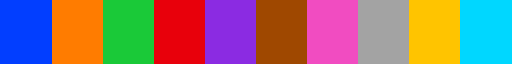

[(0.00784313725490196, 0.24313725490196078, 1.0, 0.1),
 (1.0, 0.48627450980392156, 0.0, 0.1),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549, 0.1),
 (0.9098039215686274, 0.0, 0.043137254901960784, 0.1),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215, 0.1),
 (0.6235294117647059, 0.2823529411764706, 0.0, 0.1),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392, 0.1),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098, 0.1),
 (1.0, 0.7686274509803922, 0.0, 0.1),
 (0.0, 0.8431372549019608, 1.0, 0.1)]

In [26]:
# in order to control the alpha values
# of face- and edgcolor in matplotlib patches separately
# rgba touples are required
# below color codes from matplotlib color maps are listed

# rgb colors
sns_bright_rgb = vutils.color_palette("bright", 10, True)

# rgba colors
hist_fc_alpha = 0.1
sns_bright_rgba = [(*c[:3], hist_fc_alpha) for c in sns_bright_rgb]
sns_bright_rgba

#### Number of visits per field

In [27]:
survey_names = np.unique(df_gal_vis["survey"]).tolist()
#survey_names.remove("CAI")  # remove clibration "survey"
survey_names_full = {
    "AIS": "All-sky Imaging Survey",
    "MIS": "Medium Imaging Survey",
    "DIS": "Deep Imaging Survey",
    "NGS": "Nearby Galaxy Survey",
    "CAI": "Calibration Imaging",
    "GII": "Guest Investigator Imaging",
}
survey_names

['AIS', 'CAI', 'DIS', 'GII', 'MIS', 'NGS']

Discovery potential with VASCA over TDS: 310.7x


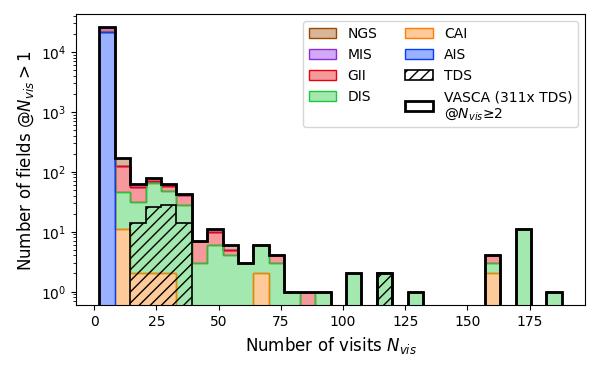

In [52]:
fig, ax = vutils.nb_fig(num="Number of visits", gr_size=6, tight_layout=True)
# Compute bins from DIS subsample
bins = np.histogram_bin_edges(df_gal_vis_agg.query("survey=='DIS' and n_visits>1")["n_visits"].values, bins="auto")

# Histogram for all DIS fields
_, _, patches_srvy = ax.hist(
    [df_gal_vis_agg.query("survey==@srvy and n_visits>1")["n_visits"].values for srvy in survey_names],
    bins=bins,
    histtype="stepfilled",
    stacked=True,
    label=survey_names,
)
for i, patch in enumerate(patches_srvy):
    patch[0].set_facecolor((*sns_bright_rgb[i][:3], 0.4))
    patch[0].set_edgecolor(sns_bright_rgb[i])

# Compare TDS data and potential data of same quality
data_tds = rg.tt_fields["nr_vis"]  # TDS data
n_visits_tds_min = rg.tt_fields["nr_vis"].min()  # Minimum number of visits in TDS
n_visits_cut = n_visits_tds_min
n_visits_cut = 2
data_vasca = df_gal_vis_agg.query("survey in @survey_names and n_visits>=@n_visits_cut")["n_visits"]  # Potential data to be analyzed with VASCA

potential = (np.histogram(data_vasca, bins=bins)[0].sum() / np.histogram(data_tds, bins=bins)[0].sum())
print(f"Discovery potential with VASCA over TDS: {potential:1.1f}x")

# Histogram for TDS fields
counts_tds, _, _ = ax.hist(
    data_tds,
    bins=bins,
    histtype="step",
    label="TDS",
    color="k",
    hatch="///",
    lw=1.2,
)
# Histogram fields perform equally good or better
counts_vasca, _, _ = ax.hist(
    data_vasca,
    bins=bins,
    histtype="step",
    label=f"VASCA ({potential:1.0f}x TDS)\n@$N_{{vis}}≥{int(n_visits_cut)}$",
    ls="-",
    color="k",
    lw=2
)


ax.legend(ncol=2)
ax.set_xlabel("Number of visits $N_{{vis}}$", fontsize=12)
ax.set_ylabel("Number of fields @$N_{{vis}}>1$", fontsize=12)
ax.set_yscale("log")

plt.savefig(f"{out_dir}/n_visits.pdf", dpi=600)
plt.savefig(f"{out_dir}/n_visits.svg", dpi=600)
plt.savefig(f"{out_dir}/n_visits.png", dpi=600)

Discovery potential with VASCA over TDS: 5.8x


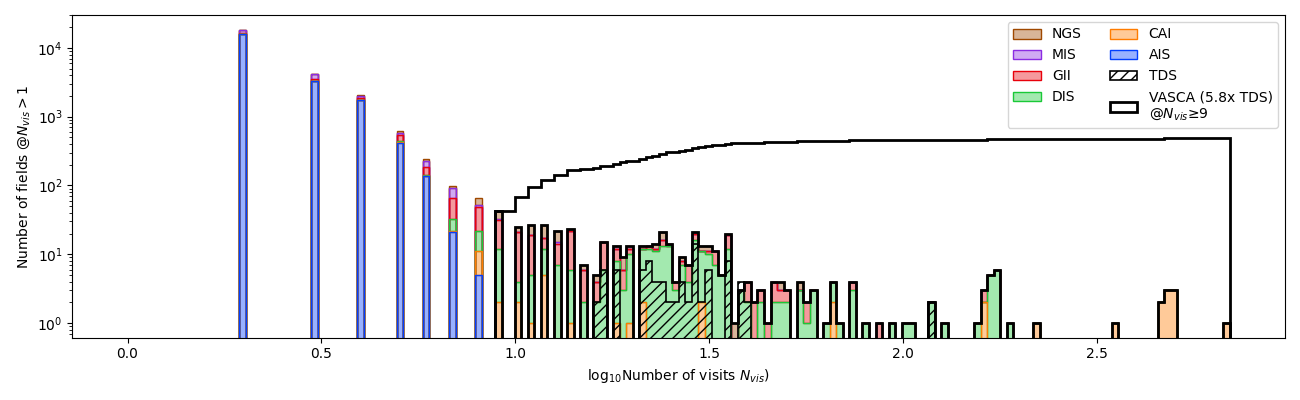

In [29]:
fig, ax = vutils.nb_fig(num="Number of visits log", figsize=(13,4), tight_layout=True)
# Compute bins from DIS subsample
#bins = np.histogram_bin_edges(df_gal_vis_agg.query("survey=='DIS' and n_visits>1")["n_visits"].values, bins="auto")
bins = np.histogram_bin_edges(np.log10(df_gal_vis_agg["n_visits"].values), bins="auto")

# Histogram for all DIS fields
_, _, patches_srvy = ax.hist(
    [np.log10(df_gal_vis_agg.query("survey==@srvy and n_visits>1")["n_visits"].values) for srvy in survey_names],
    bins=bins,
    histtype="stepfilled",
    stacked=True,
    label=survey_names,
)
for i, patch in enumerate(patches_srvy):
    patch[0].set_facecolor((*sns_bright_rgb[i][:3], 0.4))
    patch[0].set_edgecolor(sns_bright_rgb[i])

# Compare TDS data and potential data of same quality
data_tds = np.log10(rg.tt_fields["nr_vis"])  # TDS data
n_visits_tds_min = rg.tt_fields["nr_vis"].min()  # Minimum number of visits in TDS
n_visits_cut = n_visits_tds_min
n_visits_cut = 9
data_vasca = np.log10(df_gal_vis_agg.query("survey in @survey_names and n_visits>=@n_visits_cut")["n_visits"])  # Potential data to be analyzed with VASCA

potential = (np.histogram(data_vasca, bins=bins)[0].sum() / np.histogram(data_tds, bins=bins)[0].sum())
print(f"Discovery potential with VASCA over TDS: {potential:1.1f}x")

# Histogram for TDS fields
counts_tds, _, _ = ax.hist(
    data_tds,
    bins=bins,
    histtype="step",
    label="TDS",
    color="k",
    hatch="///",
    lw=1.2,
)
# Histogram fields perform equally good or better
counts_vasca, _, _ = ax.hist(
    data_vasca,
    bins=bins,
    histtype="step",
    label=f"VASCA ({potential:1.1f}x TDS)\n@$N_{{vis}}≥{int(n_visits_cut)}$",
    ls="-",
    color="k",
    lw=2
)

# Histogram fields perform equally good or better
counts_vasca_cum, _, _ = ax.hist(
    data_vasca,
    bins=bins,
    histtype="step",
    cumulative=True,
    #label=f"VASCA ({potential:1.1f}x TDS)\n@$N_{{vis}}≥{int(n_visits_cut)}$",
    ls="-",
    color="k",
    lw=2
)


ax.legend(ncol=2)
ax.set_xlabel("log$_{{10}}$Number of visits $N_{{vis}}$)")
ax.set_ylabel("Number of fields @$N_{{vis}}>1$")
ax.set_yscale("log")

6.199999999999999
Discovery potential with VASCA over TDS: 42.2x


(8.8, 972.7560014207045)

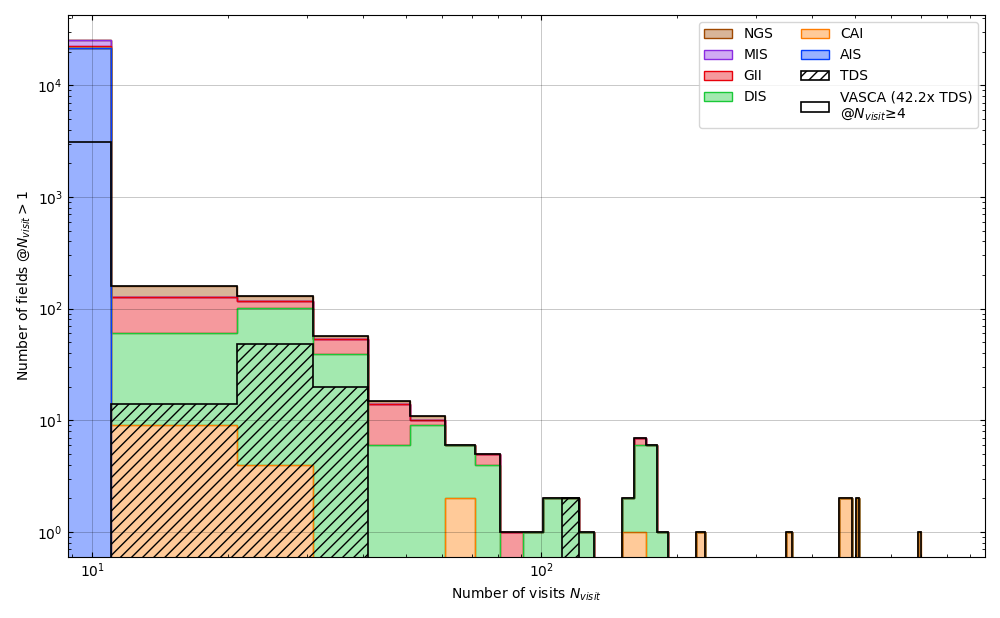

In [30]:
fig, ax = vutils.nb_fig(num="Number of visits", gr_size=10, tight_layout=True)
# Compute bins from DIS subsample
bins_DIS = np.histogram_bin_edges(df_gal_vis_agg.query("survey=='DIS' and n_visits>1")["n_visits"].values, bins="auto")
bin_size_DIS = bins_DIS[1] - bins_DIS[0] 
print(bin_size_DIS)
bins = vutils.get_hist_bins(df_gal_vis_agg["n_visits"].values, 10)

# Histogram for all DIS fields
_, _, patches_srvy = ax.hist(
    [df_gal_vis_agg.query("survey==@srvy and n_visits>1")["n_visits"].values for srvy in survey_names],
    bins=bins,
    histtype="stepfilled",
    stacked=True,
    label=survey_names,
)
for i, patch in enumerate(patches_srvy):
    patch[0].set_facecolor((*sns_bright_rgb[i][:3], 0.4))
    patch[0].set_edgecolor(sns_bright_rgb[i])

# Compare TDS data and potential data of same quality
data_tds = rg.tt_fields["nr_vis"]  # TDS data
n_visits_tds_min = rg.tt_fields["nr_vis"].min()  # Minimum number of visits in TDS
n_visits_cut = n_visits_tds_min
n_visits_cut = 4
data_vasca = df_gal_vis_agg.query("survey in @survey_names and n_visits>=@n_visits_cut")["n_visits"]  # Potential data to be analyzed with VASCA

potential = (np.histogram(data_vasca, bins=bins)[0].sum() / np.histogram(data_tds, bins=bins)[0].sum())
print(f"Discovery potential with VASCA over TDS: {potential:1.1f}x")

# Histogram for TDS fields
counts_tds, _, _ = ax.hist(
    data_tds,
    bins=bins,
    histtype="step",
    label="TDS",
    color="k",
    hatch="///",
    lw=1.2,
)
# Histogram fields perform equally good or better
counts_vasca, _, _ = ax.hist(
    data_vasca,
    bins=bins,
    histtype="step",
    label=f"VASCA ({potential:1.1f}x TDS)\n@$N_{{visit}}≥{int(n_visits_cut)}$",
    ls="-",
    color="k",
    lw=1.2
)

ax.grid(True, linewidth=0.5, color="k", alpha=0.3, zorder=0)

ax.tick_params(
    axis="y", direction="in", left=True, right=True, which="both"
)
ax.tick_params(
    axis="x", direction="in", top=True, bottom=True, which="both"
)


ax.legend(ncol=2)
ax.set_xlabel("Number of visits $N_{{visit}}$")
ax.set_ylabel("Number of fields @$N_{{visit}}>1$")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(left=8.8)

## X-match VASCA catalog to TDS

In [31]:
sel_vasca = rg.tt_sources["sel"]
tt_vasca = rg.tt_sources[sel_vasca]

print(f"Selected {len(tt_vasca)} out of {len(rg.tt_sources)} sources")

# Coordinates
pos_tds = SkyCoord(ra=tt_tds["ra"], dec=tt_tds["dec"], unit="deg", frame="icrs")
pos_vasca = SkyCoord(ra=tt_vasca["ra"], dec=tt_vasca["dec"], unit="deg", frame="icrs")

# TDS to VASCA
match_dist = 10 * u.arcsec
idx_tds, dist_tds, _ = pos_vasca.match_to_catalog_sky(pos_tds)
tt_vasca["tds_recno"]=tt_tds[idx_tds]["recno"]
tt_vasca["tds_idx"]=idx_tds
tt_vasca["tds_dist"]=dist_tds.to("arcsec")
tt_vasca["tds_match"] = tt_vasca["tds_dist"] < match_dist

# VASCA to TDS
idx_vasca, dist_vasca, _ = pos_tds.match_to_catalog_sky(pos_vasca)
tt_tds["rg_src_id"]=tt_vasca[idx_vasca]["rg_src_id"]
tt_tds["vasca_idx"]=idx_vasca
tt_tds["vasca_dist"]=dist_vasca.to("arcsec")
tt_tds["vasca_match"] = tt_tds["vasca_dist"] < match_dist

#display("Selected rg_src_ids",tt_vasca[:]["rg_src_id"].data)
#display(tt_tds[:2])

sel_tmv = tt_tds["vasca_match"]
sel_vmt = tt_vasca["tds_match"]
print("Nr. sources VASCA/TDS :",len(tt_vasca),"/",len(tt_tds))
print("Nr. associated sources VASCA/TDS:",sel_vmt.sum(),"/",sel_tmv.sum())
print("Fraction of associated VASCA/TDS sources:",sel_vmt.sum()/len(tt_vasca),"/",sel_tmv.sum()/len(tt_tds))

Selected 1649 out of 255727 sources
Nr. sources VASCA/TDS : 1649 / 1078
Nr. associated sources VASCA/TDS: 580 / 582
Fraction of associated VASCA/TDS sources: 0.35172832019405703 / 0.5398886827458256


# Alternative comparison

## Load catalog data

In [32]:
# TDS
tds_catalog = "./TDS-ApJ_766_60/table4.fit"
tt_tds = Table.read(tds_catalog, hdu="J_ApJ_766_60_table4")

df_tds = tt_tds.to_pandas()
for key in ["ID", "l_mlow", "l_Dmmax", "l_sigint", "l_Sd", "l_Sy", "LC", "Mph", "OT", "X", "Class"]:
    df_tds[key] = df_tds[key].values.astype(str)

# VASCA catalog of 5σ variable UV sources
tt_vasca = rg.tt_sources[rg.tt_sources["sel"]]

In [33]:
# Flatten, i.e., unpack multi-filter columns
multi_cols = [col for col in tt_vasca.columns if len(tt_vasca[col].shape) > 1]
single_cols = [col for col in tt_vasca.columns if len(tt_vasca[col].shape) == 1]
new_cols = [
    *single_cols,
    *[f"{col}_nuv" for col in multi_cols],
    *[f"{col}_fuv" for col in multi_cols],
]
vasca_cols_flat = [*[tt_vasca[col] for col in single_cols]]
for idx, obs_filter in zip([0,1], ["nuv", "fuv"]):
    tt_temp = Table([tt_vasca[col][:, idx] for col in multi_cols])

    for col in multi_cols:
        tt_temp.rename_column(col, f"{col}_{obs_filter}")


    vasca_cols_flat = [
        *vasca_cols_flat,
        *[tt_temp[col] for col in tt_temp.columns]
    ]
tt_vasca_flat = Table(vasca_cols_flat)
tt_vasca = tt_vasca_flat

In [34]:
tt_vasca_flat

fd_src_id,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,pos_rchiq,assoc_id,assoc_dist,sel,rg_fd_id,rg_src_id,nr_fd_srcs,nr_det_nuv,obs_filter_id_nuv,flux_nuv,flux_err_nuv,flux_nxv_nuv,flux_var_nuv,flux_cpval_nuv,flux_rchiq_nuv,assoc_ffactor_nuv,assoc_fdiff_s2n_nuv,nr_det_fuv,obs_filter_id_fuv,flux_fuv,flux_err_fuv,flux_nxv_fuv,flux_var_fuv,flux_cpval_fuv,flux_rchiq_fuv,assoc_ffactor_fuv,assoc_fdiff_s2n_fuv
,deg,deg,arcsec,,arcsec2,,,,arcsec,,,,,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,
int32,float64,float64,float32,float32,float32,float32,float32,int64,float32,bool,int32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32
-1,334.6040276905102,0.4073700400139436,0.0746687,-5.6494123e-08,0.11292992,0.9999946,0.33045548,51,0.16414735,True,-1,66,4,51,1,70.07051,0.23644978,0.001175622,8.690477,5.5808305e-12,3.0072052,0.9805896,-4.5939016,8,2,3.140408,0.18728638,0.044924546,0.7962941,0.062826045,1.9150549,0.95898515,-0.4165175
-1,334.3717176032489,0.1425467399121394,0.061520703,-1.6523775e-09,0.25529367,0.39739534,0.89754647,127,0.71222633,True,-1,125,4,66,1,144.96884,0.2756732,0.0006388653,18.63679,3.2101275e-22,3.7245073,1.0180447,7.2789655,10,2,131.19595,0.894873,0.0010078294,33.34885,5.73519e-06,4.51926,0.9992297,-0.077710085
-1,334.16722924495986,0.27231054057344384,0.123911865,-1.3378893e-07,0.15837234,0.9962184,0.3796424,184,0.1259293,True,-1,159,4,19,1,32.007793,0.3055451,0.007956937,10.033219,4.562563e-12,5.1543627,0.9437589,-5.512789,8,2,10.876374,0.34918544,0.026447881,4.1487355,0.00011173472,4.230629,0.9874041,-0.25981584
-1,333.3256310259238,-0.13628023315448407,0.06641622,-5.4513885e-07,0.08558129,1.0,0.2994884,360,0.029016083,True,-1,239,4,61,1,97.00277,0.22803459,0.01718866,165.13599,0.0,56.16798,0.98304296,-5.6715817,6,2,2.4881709,0.21249524,0.016910993,0.51610905,0.27891105,1.258229,1.3240169,1.8826966
-1,333.2779024012591,-0.2326492441767074,0.10454843,-2.0436177e-07,0.22899462,0.9994686,0.4266416,370,0.1761394,True,-1,240,4,37,1,14.463752,0.1735562,0.04033973,9.616125,1.46e-43,8.360293,0.9815832,-1.244486,9,2,5.9984956,0.29139164,0.05771878,2.993848,0.006294466,2.6676369,0.95419365,-0.61294246
-1,242.13061058556966,54.35235232383914,0.09614244,-3.223636e-12,0.27302176,0.28292465,0.7374028,1044,0.07007824,True,-1,406,4,30,1,16.78025,0.17863573,0.017031763,5.7768245,6.4988633e-22,5.8676844,0.9652967,-2.6476834,10,2,8.580403,0.32719588,0.0049133594,1.5590422,0.23379327,1.2943969,0.99654776,-0.06395665
-1,242.06767139239636,55.05962386751517,0.10780618,-1.3700729e-12,0.6249373,1.9448324e-05,1.488273,1122,0.0817816,True,-1,431,4,26,1,18.707724,0.21440011,0.039773323,15.173762,0.0,12.497078,0.96429235,-2.5763066,8,2,8.331067,0.37781796,0.005724044,1.6968313,0.27151927,1.2492235,0.9943162,-0.09590134
-1,241.99273081592867,54.84632885630877,0.13996045,-2.3525084e-12,0.34631437,0.21704613,0.88594395,1223,0.9767603,True,-1,463,4,12,1,45.626778,0.4442185,0.028509669,61.765736,0.0,25.948744,1.060674,5.3437324,8,2,16.359665,0.48281956,0.012937807,5.784729,0.00044659153,3.7560031,0.90414053,-2.551196


## Positional cross-matching

In [35]:
# Select coordinates data
pos_tds = SkyCoord(ra=tt_tds["RAJ2000"], dec=tt_tds["DEJ2000"], unit="deg", frame="icrs")
pos_vasca = SkyCoord(ra=tt_vasca["ra"], dec=tt_vasca["dec"], unit="deg", frame="fk5")

In [36]:
# Cross-match to TDS
match_idx_tds, match_dist_tds, _ = match_coordinates_sky(pos_vasca, pos_tds)

# Add catalog index of matched source
tt_vasca["match_idx_tds"] = match_idx_tds

# Add distance on sky to matched source
tt_vasca["match_dist_tds"] =  match_dist_tds
tt_vasca["match_dist_tds"].unit = u.deg

# Add magnitude of matched source
tt_vasca["match_mag_tds"] = tt_tds["mlow"][match_idx_tds]
tt_vasca["match_mag_tds"].unit = u.mag

# Add intrinsic variability of matched source
tt_vasca["match_sigint_tds"] = tt_tds["sigint"][match_idx_tds]
tt_vasca["match_sigint_tds"].unit = u.mag

# Add source classification of matched source
tt_vasca["match_class_tds"] = tt_tds["Class"][match_idx_tds]

# Add light curve type of matched source
tt_vasca["match_lc_tds"] = tt_tds["LC"][match_idx_tds]


In [37]:
tt_vasca

fd_src_id,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,pos_rchiq,assoc_id,assoc_dist,sel,rg_fd_id,rg_src_id,nr_fd_srcs,nr_det_nuv,obs_filter_id_nuv,flux_nuv,flux_err_nuv,flux_nxv_nuv,flux_var_nuv,flux_cpval_nuv,flux_rchiq_nuv,assoc_ffactor_nuv,assoc_fdiff_s2n_nuv,nr_det_fuv,obs_filter_id_fuv,flux_fuv,flux_err_fuv,flux_nxv_fuv,flux_var_fuv,flux_cpval_fuv,flux_rchiq_fuv,assoc_ffactor_fuv,assoc_fdiff_s2n_fuv,match_idx_tds,match_dist_tds,match_mag_tds,match_sigint_tds,match_class_tds,match_lc_tds
,deg,deg,arcsec,,arcsec2,,,,arcsec,,,,,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,deg,mag,mag,,
int32,float64,float64,float32,float32,float32,float32,float32,int64,float32,bool,int32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64,float32,float32,bytes12,bytes1
-1,334.6040276905102,0.4073700400139436,0.0746687,-5.6494123e-08,0.11292992,0.9999946,0.33045548,51,0.16414735,True,-1,66,4,51,1,70.07051,0.23644978,0.001175622,8.690477,5.5808305e-12,3.0072052,0.9805896,-4.5939016,8,2,3.140408,0.18728638,0.044924546,0.7962941,0.062826045,1.9150549,0.95898515,-0.4165175,737,0.07506632993567856,21.81,0.14,QSO,F
-1,334.3717176032489,0.1425467399121394,0.061520703,-1.6523775e-09,0.25529367,0.39739534,0.89754647,127,0.71222633,True,-1,125,4,66,1,144.96884,0.2756732,0.0006388653,18.63679,3.2101275e-22,3.7245073,1.0180447,7.2789655,10,2,131.19595,0.894873,0.0010078294,33.34885,5.73519e-06,4.51926,0.9992297,-0.077710085,73,0.2559677342779562,18.15,0.49,RRL,V
-1,334.16722924495986,0.27231054057344384,0.123911865,-1.3378893e-07,0.15837234,0.9962184,0.3796424,184,0.1259293,True,-1,159,4,19,1,32.007793,0.3055451,0.007956937,10.033219,4.562563e-12,5.1543627,0.9437589,-5.512789,8,2,10.876374,0.34918544,0.026447881,4.1487355,0.00011173472,4.230629,0.9874041,-0.25981584,95,0.1305564423453458,22.17,0.32,QSO,V
-1,333.3256310259238,-0.13628023315448407,0.06641622,-5.4513885e-07,0.08558129,1.0,0.2994884,360,0.029016083,True,-1,239,4,61,1,97.00277,0.22803459,0.01718866,165.13599,0.0,56.16798,0.98304296,-5.6715817,6,2,2.4881709,0.21249524,0.016910993,0.51610905,0.27891105,1.258229,1.3240169,1.8826966,697,0.09124924046435147,21.60,0.14,STAR,V
-1,333.2779024012591,-0.2326492441767074,0.10454843,-2.0436177e-07,0.22899462,0.9994686,0.4266416,370,0.1761394,True,-1,240,4,37,1,14.463752,0.1735562,0.04033973,9.616125,1.46e-43,8.360293,0.9815832,-1.244486,9,2,5.9984956,0.29139164,0.05771878,2.993848,0.006294466,2.6676369,0.95419365,-0.61294246,503,0.00017923135398738958,20.77,0.32,AGN,V
-1,242.13061058556966,54.35235232383914,0.09614244,-3.223636e-12,0.27302176,0.28292465,0.7374028,1044,0.07007824,True,-1,406,4,30,1,16.78025,0.17863573,0.017031763,5.7768245,6.4988633e-22,5.8676844,0.9652967,-2.6476834,10,2,8.580403,0.32719588,0.0049133594,1.5590422,0.23379327,1.2943969,0.99654776,-0.06395665,971,0.0403584045602833,19.88,0.22,QSO,V
-1,242.06767139239636,55.05962386751517,0.10780618,-1.3700729e-12,0.6249373,1.9448324e-05,1.488273,1122,0.0817816,True,-1,431,4,26,1,18.707724,0.21440011,0.039773323,15.173762,0.0,12.497078,0.96429235,-2.5763066,8,2,8.331067,0.37781796,0.005724044,1.6968313,0.27151927,1.2492235,0.9943162,-0.09590134,853,8.983584832287567e-05,20.85,0.22,QSO,
-1,241.99273081592867,54.84632885630877,0.13996045,-2.3525084e-12,0.34631437,0.21704613,0.88594395,1223,0.9767603,True,-1,463,4,12,1,45.626778,0.4442185,0.028509669,61.765736,0.0,25.948744,1.060674,5.3437324,8,2,16.359665,0.48281956,0.012937807,5.784729,0.00044659153,3.7560031,0.90414053,-2.551196,786,0.00014622522717838558,20.21,0.26,QSO,V


In [38]:
579/1649 *100

35.112189205579135

In [39]:
# Select matched VASCA-sources for given distance cut
dist_lim = (10 * u.arcsec).to("deg")
sel_dist = match_dist_tds <= dist_lim

# Include only unique matches, i.e., reject sources with match conflicts
_, unique_index, index_counter = np.unique(match_idx_tds[sel_dist], return_index=True, return_counts=True)
sel_single_match = index_counter <= 1

tt_vasca_matched = tt_vasca[sel_dist][unique_index]

print("total:",len(match_idx_tds[sel_dist]), "unique:", len(np.unique(match_idx_tds[sel_dist])))

total: 580 unique: 579


In [40]:
tt_vasca_matched

fd_src_id,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,pos_rchiq,assoc_id,assoc_dist,sel,rg_fd_id,rg_src_id,nr_fd_srcs,nr_det_nuv,obs_filter_id_nuv,flux_nuv,flux_err_nuv,flux_nxv_nuv,flux_var_nuv,flux_cpval_nuv,flux_rchiq_nuv,assoc_ffactor_nuv,assoc_fdiff_s2n_nuv,nr_det_fuv,obs_filter_id_fuv,flux_fuv,flux_err_fuv,flux_nxv_fuv,flux_var_fuv,flux_cpval_fuv,flux_rchiq_fuv,assoc_ffactor_fuv,assoc_fdiff_s2n_fuv,match_idx_tds,match_dist_tds,match_mag_tds,match_sigint_tds,match_class_tds,match_lc_tds
,deg,deg,arcsec,,arcsec2,,,,arcsec,,,,,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,deg,mag,mag,,
int32,float64,float64,float32,float32,float32,float32,float32,int64,float32,bool,int32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64,float32,float32,bytes12,bytes1
-1,333.83249666535266,-0.5490986252706092,0.11815439,-4.3910987e-08,0.3679568,0.6763975,0.6106738,12345,0.067047365,True,-1,6597,2,33,1,8.891106,0.17424151,61.05326,4827.889,0.0,585.528,0.34561962,-66.92679,5,2,5.307208,0.37160584,-0.021160278,0.1407426,0.9395415,0.19795468,1.0275732,0.2492982,1,0.00010970446164942585,21.14,0.99,CV,F
-1,242.03952410576227,54.35865542986043,0.123211496,2.64743e-12,1.0877984,1.8169729e-05,1.8067808,1166,0.16106613,True,-1,2124,3,25,1,13.369682,0.19070622,3.6105638,646.90314,0.0,403.81125,0.7241175,-20.402456,1,2,4.3142486,0.70548505,-100.0,-100.0,-1.0,-1.0,1.8836405,2.689654,2,0.0001146198328513976,22.89,1.37,CV,V
-1,242.3679940556358,53.6734928074704,0.21433103,-3.5976873e-12,0.32065862,0.32529438,0.7639206,240167,0.17213278,True,-1,101912,1,9,1,7.956287,0.26963854,10.739779,680.8981,0.0,297.647,1.0412223,0.98138416,-1,-1,-1.0,-1.0,-100.0,-1.0,-1.0,-1.0,1.0,0.0,3,0.0004317833842020238,23.03,1.23,Galaxy Trans,F
-1,212.50244158007058,52.415252977683835,0.5433721,-100.0,-1296000000.0,1.0,-1.0,350016,0.29627043,True,-1,143865,1,1,1,51.7385,1.3613272,-100.0,-100.0,-1.0,-1.0,13.162298,34.885628,-1,-1,-1.0,-1.0,-100.0,-1.0,-1.0,-1.0,1.0,0.0,4,5.458769378769991e-05,23.10,3.51,Mdw,F
-1,53.1679460769583,-26.356468603513978,0.24778359,-4.037318e-12,0.4928808,0.43455052,0.7177122,503447,0.34232947,True,-1,203987,1,10,1,3.1496837,0.19168434,0.6294589,6.6389217,2.0498682e-14,9.389266,0.6878818,-6.111854,-1,-1,-1.0,-1.0,-100.0,-1.0,-1.0,-1.0,1.0,0.0,5,0.0002400234126685565,23.06,0.73,Mdw,
-1,36.646800073695715,-5.088386252803969,0.33849376,-4.799581e-10,0.44910148,0.39009827,0.64856994,98909,0.17338978,True,-1,48763,2,4,1,4.4510937,0.31663093,11.773253,233.87256,0.0,227.31561,1.510891,4.3800716,1,2,11.626038,1.0923111,-100.0,-100.0,-1.0,-1.0,1.0,0.0,9,0.00021509498693038733,22.95,0.95,Mdw,
-1,36.197622514513974,-5.740764705726542,0.29490831,-5.949129e-10,0.44920346,0.6365848,0.5040873,100784,0.10376315,True,-1,235368,1,7,1,6.686253,0.29830056,2.8110936,126.4805,0.0,111.66436,1.3024863,4.3981833,-1,-1,-1.0,-1.0,-100.0,-1.0,-1.0,-1.0,-0.11915742,-5.7275677,10,0.00034656297697695855,22.95,0.94,Mdw,V
-1,333.0055592679332,-0.057347299198781475,0.123206854,-3.714049e-06,0.33237797,0.85593295,0.5727832,163631,0.1641174,True,-1,76856,1,33,1,9.426931,0.16539013,1.4990791,134.3218,0.0,80.68806,0.7729239,-11.720497,-1,-1,-1.0,-1.0,-100.0,-1.0,-1.0,-1.0,1.0,0.0,11,0.0002948155429351242,21.61,0.75,RRAB,V


In [41]:
# As DataFrame
df_vasca_matched = tt_vasca_matched.to_pandas()

# Convert string columns to proper strings
df_vasca_matched["match_class_tds"] = df_vasca_matched["match_class_tds"].values.astype(str)
df_vasca_matched["match_lc_tds"] = df_vasca_matched["match_lc_tds"].values.astype(str)

# Sorted by survey and visit ID
df_vasca_matched_grpd = df_vasca_matched.groupby(["match_class_tds"],as_index=True)

#### Classification

##### Variability type

,?,Flare/Trans.,Variable
VASCA,121,91,367
TDS,222,261,595


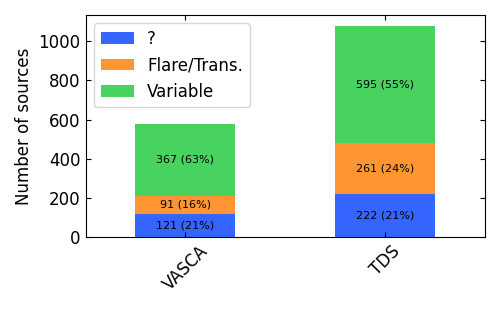

In [42]:
bar_data = dict()

lc_types = ["?", "Flare/Trans.", "Variable"]
classes = list(set(df_vasca_matched.match_class_tds))

bar_data["VASCA"] = {k: v for k,v in zip(lc_types, np.unique(df_vasca_matched.match_lc_tds, return_counts=True)[1])}
bar_data["TDS"] = {k: v for k,v in zip(lc_types, np.unique(tt_tds["LC"].data, return_counts=True)[1])}

df_bar_data = pd.DataFrame(bar_data).T
display(df_bar_data)

fig, ax = vutils.nb_fig(num="LC bar", tight_layout=True, gr_size=5)

n_srcs = [len(df_vasca_matched), len(tt_tds)]

df_bar_data.plot.bar(ax=ax, stacked=True, rot=45, color=[(*c[:3], 0.8) for c in sns_bright_rgb[:3]], ylabel="Number of sources", xlabel=None, fontsize=12)
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    labels = [f"{l:1.0f} ({l/n_srcs[i] * 100:1.0f}%)" for i, l in enumerate(labels)]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center', fontsize=8)
    
    ax.tick_params(
        axis="y", direction="in", left=True, right=True, which="both"
    )
    ax.tick_params(
        axis="x", direction="in", top=True, bottom=True, which="both"
    )
ax.set_ylabel("Number of sources", fontsize=12)
ax.legend(fontsize=12)

plt.savefig(f"{out_dir}/lc_bar.pdf", dpi=600)
plt.savefig(f"{out_dir}/lc_bar.svg", dpi=600)
plt.savefig(f"{out_dir}/lc_bar.png", dpi=600)

##### Source type

,?,AGN,Galaxy,Mdw,Misc,Orphan,Point,QSO,RRL,STAR
VASCA,53,173,23,15,5,1,28,247,27,7
TDS,117,305,99,53,6,20,67,358,35,18


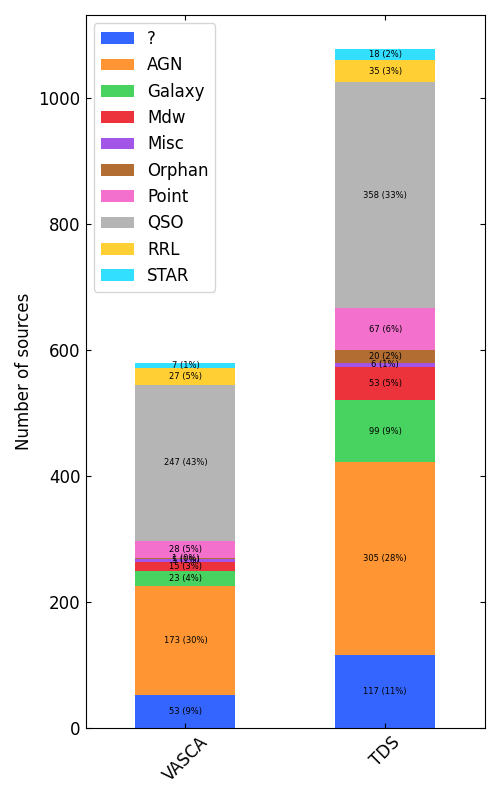

In [43]:
classes = sorted(["Galaxy", "Orphan", "Point", "STAR", "Mdw", "RRL", "QSO", "AGN", "?", "Misc"])
counts_vasca = dict.fromkeys(classes, 0)
counts_tds = dict.fromkeys(classes, 0)
for key in classes:
    if key == "Galaxy":
        classes_list = ["Galaxy Flare", "Galaxy Trans"]
    elif key == "Orphan":
        classes_list = ["Orphan Trans", "Orphan Var"]
    elif key == "Point":
        classes_list = ["Point Flare", "Point Trans", "Point Var"]
    elif key == "Misc":
        classes_list = ["BHB", "CV", "RRAB", 'S Boo (LPV)']
    else:
        classes_list = [key]
    
    counts_vasca[key] = len(df_vasca_matched.query("match_class_tds in @classes_list"))
    counts_tds[key] = len(df_tds.query("Class in @classes_list"))

bar_data["VASCA"] = counts_vasca
bar_data["TDS"] = counts_tds

df_bar_data = pd.DataFrame(bar_data).T
display(df_bar_data)

fig, ax = vutils.nb_fig(num="Class bar", tight_layout=True, figsize=(5,8))

n_srcs = [len(df_vasca_matched), len(tt_tds)]

df_bar_data.plot.bar(ax=ax, stacked=True, rot=45, color=[(*c[:3], 0.8) for c in sns_bright_rgb[:10]], ylabel="Number of sources", xlabel=None, fontsize=12)
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else np.nan for v in c]
    labels = [f"{l:1.0f} ({l/n_srcs[i] * 100:1.0f}%)" for i, l in enumerate(labels)]
    labels = [l if not "nan" in l else "" for l in labels]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center', fontsize=6)
    
    ax.tick_params(
        axis="y", direction="in", left=True, right=True, which="both"
    )
    ax.tick_params(
        axis="x", direction="in", top=True, bottom=True, which="both"
    )
ax.set_ylabel("Number of sources", fontsize=12)
ax.legend(fontsize=12)

plt.savefig(f"{out_dir}/class_bar.pdf", dpi=600)
plt.savefig(f"{out_dir}/class_bar.svg", dpi=600)
plt.savefig(f"{out_dir}/class_bar.png", dpi=600)

In [44]:
tt_vasca.info()

<Table length=1649>
        name         dtype     unit    format                                         description                                         
------------------- ------- --------- ------- --------------------------------------------------------------------------------------------
          fd_src_id   int32                                                                    Source ID associated to the visit detection
                 ra float64       deg                                                                       Center RA of the field (J2000)
                dec float64       deg                                                                      Center Dec of the field (J2000)
            pos_err float32    arcsec                                                                                 Visit position error
            pos_nxv float32                                             Position normalized excess variance, entries for different filters
       

#### Nearest on-sky separation

VASCA, mean pos. error 0.167


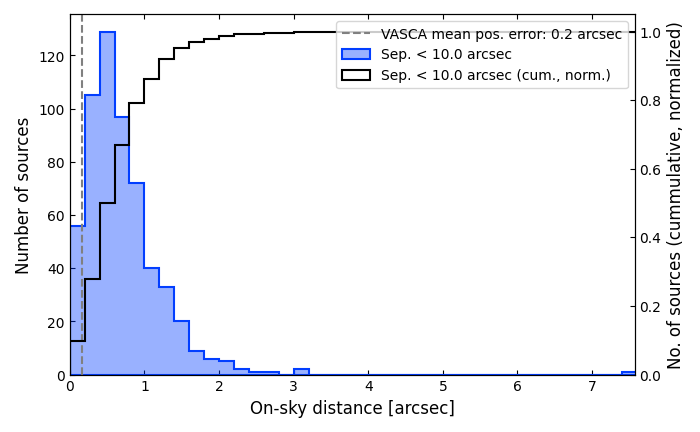

In [45]:
fig, ax = vutils.nb_fig(num="match distance", gr_size=7, tight_layout=True)

bins = vutils.get_hist_bins(tt_vasca_matched["match_dist_tds"].to("arcsec").data, 0.2)
_, _, hpatch = ax.hist(
    tt_vasca_matched["match_dist_tds"].to("arcsec").data,
    bins=bins,
    cumulative=False,
    histtype="stepfilled",
    #alpha=0.5,
    edgecolor=sns_bright_rgb[0][:3],
    facecolor=(*sns_bright_rgb[0][:3], 0.4),
    lw=1.5,
    zorder=2,
    label=f"Sep. < {dist_lim.to('arcsec')}"
)

vasca_pos_err_mean = np.mean(np.asarray(tt_vasca["pos_err"].to("arcsec").data))
print(f'VASCA, mean pos. error {vasca_pos_err_mean:1.3f}')
vline = ax.axvline(
    vasca_pos_err_mean,
    ls="--",
    lw=1.5,
    color="gray",
    label=f"VASCA mean pos. error: {vasca_pos_err_mean:1.1f} arcsec"
)
#ax.set_xlim((0,5))
ax.set_ylabel("Number of sources", fontsize=12)
ax.set_xlabel("On-sky distance [arcsec]", fontsize=12)

#ax.grid(True, linewidth=0.5, color="k", alpha=0.3, zorder=0)
ax.tick_params(
    axis="y", direction="in", left=True, right=False, which="both"
)
ax.tick_params(
    axis="x", direction="in", top=True, bottom=True, which="both"
)

ax.set_xlim(left=0, right=7.57)

ax = ax.twinx()
_, _, cpatch = ax.hist(
    tt_vasca_matched["match_dist_tds"].to("arcsec").data,
    bins=bins,
    cumulative=True,
    density=True,
    histtype="step",
    lw=1.5,
    color="k",
    zorder=1,
    label=f"Sep. < {dist_lim.to('arcsec')} (cum., norm.)"
)

ax.set_ylabel("No. of sources (cummulative, normalized)", fontsize=12)
#ax.set_yscale("log")
#ax.set_xscale("log")
ax.legend(handles=[vline, hpatch[0], cpatch[0]], fontsize=10, loc="upper right")


ax.tick_params(
    axis="y", direction="in", left=False, right=True, which="both"
)
plt.savefig(f"{out_dir}/match_dist.pdf", dpi=600)
plt.savefig(f"{out_dir}/match_dist.svg", dpi=600)
plt.savefig(f"{out_dir}/match_dist.png", dpi=600)

In [46]:
rg.tt_coadd_sources[rg.tt_coadd_sources["sel"]]["pos_err"].mean()

0.547372

In [47]:
pos_coadd = SkyCoord(ra=rg.tt_coadd_sources["ra"], dec=rg.tt_coadd_sources["dec"], unit="deg", frame="fk5")
match_idx_coadd, match_dist_coadd, _ = match_coordinates_sky(pos_vasca, pos_coadd)

In [48]:
(np.array(match_dist_coadd.to("arcsec").data)<5).sum()/len(match_dist_coadd) * 100

98.9084293511219

In [49]:
rg.tt_coadd_sources

fd_src_id,nr_det,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,pos_rchiq,assoc_id,assoc_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,assoc_ffactor,assoc_fdiff_s2n,rg_fd_id,coadd_src_id,nr_fd_dets
,,deg,deg,arcsec,,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32,float32,int32,int32,int32
-1,3 .. 3,214.73269368570712,52.992613679338604,0.23893142,-4.157876e-12,0.35729498,0.08153571,1.054201,-1,-1.0,1 .. 2,True,9.45495 .. 6.024303,0.14035879 .. 0.29843777,0.00013569597 .. -0.004802076,0.07301279 .. 0.10693922,0.27299273 .. 0.6851718,1.2983102 .. 0.37808567,-100.0,-10000.0,-1,0,-1
-1,3 .. 3,214.70455840032866,52.98914652552831,0.27047834,-6.905047e-12,0.25710347,0.38082713,0.5929656,-1,-1.0,1 .. 2,True,4.182869 .. 1.8976561,0.12316314 .. 0.19089095,-0.0018462812 .. 0.025226709,0.017014917 .. 0.20361167,0.7370974 .. 0.14556044,0.30503523 .. 1.9271638,-100.0,-10000.0,-1,1,-1
-1,3 .. 3,214.70056056344342,53.0057942542056,0.2859053,-5.017401e-12,0.65043515,0.026707895,1.3856786,-1,-1.0,1 .. 2,True,2.368901 .. 2.299345,0.13099067 .. 0.2679018,-0.00795501 .. -0.00801504,0.010651361 .. 0.17325114,0.83830833 .. 0.43981922,0.17636932 .. 0.8213915,-100.0,-10000.0,-1,2,-1
-1,3 .. 3,214.69880005772106,53.00025586837522,0.28906184,-5.2540615e-12,0.88159347,0.006340231,1.7556136,-1,-1.0,1 .. 2,True,2.7957838 .. 1.6111044,0.12625754 .. 0.18228653,-0.0014881965 .. -0.022555709,0.036399983 .. 0.0565988,0.45653147 .. 0.55263484,0.7840977 .. 0.5930579,-100.0,-10000.0,-1,3,-1
-1,3 .. 2,214.71955243180057,53.03161199493098,0.28925857,-5.736671e-12,0.3646083,0.099462986,1.0419219,-1,-1.0,1 .. 2,True,2.4087532 .. 1.1334323,0.09896709 .. 0.17166321,-0.0041321516 .. 0.018966617,0.006412644 .. 0.09344127,0.80150235 .. 0.2447993,0.2212674 .. 1.3527422,-100.0,-10000.0,-1,4,-1
-1,3 .. 2,214.71807634821783,53.021997163834875,0.30393106,-9.186777e-12,0.21875747,0.5439227,0.40773165,-1,-1.0,1 .. 2,True,2.2669907 .. 1.4149934,0.1007028 .. 0.19467114,-0.0065800794 .. 0.34495318,0.0015183687 .. 0.79175234,0.96567243 .. 0.0051313695,0.034930605 .. 7.8325486,-100.0,-10000.0,-1,5,-1
-1,2 .. 3,150.01413684844337,3.165341269954988,0.2958229,3.4499223e-09,0.7509632,0.022804732,1.5344431,-1,-1.0,1 .. 2,True,4.0336957 .. 0.89047825,0.16413437 .. 0.10471577,0.008596951 .. 0.08208883,0.19623 .. 0.10084328,0.062030535 .. 0.071189955,3.482245 .. 2.6424036,-100.0,-10000.0,-1,6,-1
-1,2 .. 2,334.8964966341267,0.38953938267852617,0.3022907,-9.882743e-08,0.01251479,0.9828895,0.034236677,-1,-1.0,1 .. 2,True,4.943203 .. 3.1560848,0.11664892 .. 0.34490883,-0.00011910407 .. 0.015088468,0.024734952 .. 0.42429596,0.3441999 .. 0.21335465,0.8947257 .. 1.548516,-100.0,-10000.0,-1,7,-1


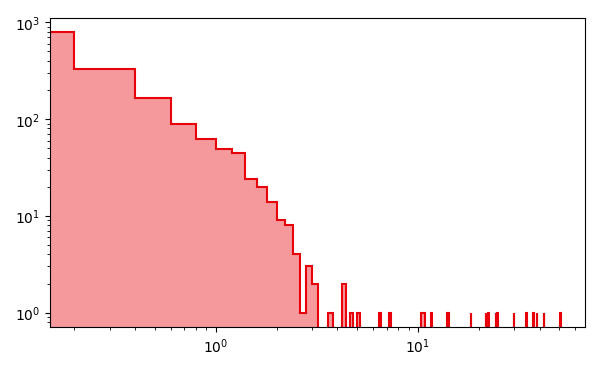

In [50]:
fig, ax = vutils.nb_fig(num="coadd match", gr_size=6, layout="tight")

bins = vutils.get_hist_bins(match_dist_coadd.to("arcsec").data, 0.2)
_ = ax.hist(
    match_dist_coadd.to("arcsec").data,
    bins=bins,
    histtype="stepfilled",
    #alpha=0.5,
    edgecolor=sns_bright_rgb[3][:3],
    facecolor=(*sns_bright_rgb[3][:3], 0.4),
    lw=1.5,
    zorder=2,
    #label=f"Sep. < {dist_lim.to('arcsec')}"
)
ax.set_yscale("log")
ax.set_xscale("log")

In [51]:
# PS1-10jh
target_coord_ps1_10jh = SkyCoord(ra=242.36789, dec=53.67333, frame="icrs", unit=u.degree)
sel_sep_ps1_10jh = region_coords.separation(target_coord_ps1_10jh) < 5*u.arcsec
display(rg.tt_sources[sel_sep_ps1_10jh])

NameError: name 'region_coords' is not defined

In [ ]:
src, dist = rg.get_src_from_sky_pos(target_coord_ps1_10jh.ra, target_coord_ps1_10jh.dec)

In [ ]:
src.tt_sources